In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-darkgrid')

In [4]:
def scrape_vietnamairlines():
    url = "https://www.vietnamairlines.com/vi/vn/home"
    page = requests.get(url).text
    soup = BeautifulSoup(page, "html.parser")

    price = soup.find_all("div", class_="fr-clearfix fr-fare-item-price-currency  fr-1572856377  fr-d-flex  fr-648105959 fr-1271692598")
    origin_city = soup.find_all("div", class_="fare-item-origin-city-name")
    dest_city =  soup.find_all("div", class_="fare-item-destination-city-name  fr-1744631283")

    flight_list = []
    for origin_city, origin_city, dest_city in zip(origin_city, origin_city, dest_city):
        flight_list.append({
            "SRC": origin_city.find("span", class_="fr-span fr-pr-1  fr-float-left").text.strip(),
            "DEST": dest_city.find("span", class_="fr-span fr-pr-1  fr-float-left".text.strip()),
            "Price":price.find("span", class_="fr-span fr-float-left").replace(",", "").strip()
        })
    return flight_list


In [5]:
def save_flight_data_weekly():
    vietnamairlines_data = scrape_vietnamairlines()
    df = pd.DataFrame(vietnamairlines_data)
    df.to_csv('flight_prices_weekly.csv', mode='a', header=False, index=False)

# Data Explore

In [7]:
# Third party dataset 'flight_scrapped.csv'
raw_data = pd.read_csv('flight_scrapped.csv')

In [8]:
raw_data.head(5)

,price,airline,fare_class,depart_time,depart_date,arrival_time,arrival_date,src,dest,cabin_luggage,hand_luggage
0,2826000,VietnamAirlines,economy,morning,24 th 6,morning,24 th 6,CXR,HAN,23,12
1,2189000,VietJetAir,economy,morning,24 th 6,morning,24 th 6,CXR,HAN,0,7
2,1648000,VietnamAirlines,economy,night,24 th 6,night,25 th 6,CXR,HAN,23,12
3,1854000,VietJetAir,economy,night,24 th 6,night,25 th 6,CXR,HAN,0,7
4,1875000,VietnamAirlines,economy,night,24 th 6,night,25 th 6,CXR,HAN,23,12


In [9]:
raw_data.nunique()

price            240
airline            3
fare_class         2
depart_time        4
depart_date       62
arrival_time       4
arrival_date      63
src                5
dest               5
cabin_luggage      7
hand_luggage       5
dtype: int64

In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159963 entries, 0 to 159962
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   price          159963 non-null  int64 
 1   airline        159963 non-null  object
 2   fare_class     159963 non-null  object
 3   depart_time    159963 non-null  object
 4   depart_date    159963 non-null  object
 5   arrival_time   159963 non-null  object
 6   arrival_date   159963 non-null  object
 7   src            159963 non-null  object
 8   dest           159963 non-null  object
 9   cabin_luggage  159963 non-null  int64 
 10  hand_luggage   159963 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 13.4+ MB


In [11]:
df = raw_data[['airline', 'fare_class', 'depart_date', 'src', 'dest', 'price']]
df

,airline,fare_class,depart_date,src,dest,price
0,VietnamAirlines,economy,24 th 6,CXR,HAN,2826000
1,VietJetAir,economy,24 th 6,CXR,HAN,2189000
2,VietnamAirlines,economy,24 th 6,CXR,HAN,1648000
3,VietJetAir,economy,24 th 6,CXR,HAN,1854000
4,VietnamAirlines,economy,24 th 6,CXR,HAN,1875000
...,...,...,...,...,...,...
159958,VietnamAirlines,business,24 th 8,SGN,PQC,4024000
159959,VietnamAirlines,business,24 th 8,SGN,PQC,4024000
159960,VietnamAirlines,business,24 th 8,SGN,PQC,4024000
159961,VietnamAirlines,business,24 th 8,SGN,PQC,4024000


In [12]:
df.dtypes

airline        object
fare_class     object
depart_date    object
src            object
dest           object
price           int64
dtype: object

In [13]:
# Loại bỏ 'th' và tạo chuỗi datetime
df['depart_date'] = df['depart_date'].astype(str)
year = 2024
df['depart_date'] = df['depart_date'].str.replace('th', '').str.strip() + f' {year}'

# Chuyển đổi về dạng datetime
df['depart_date'] = pd.to_datetime(df['depart_date'], format='%d %m %Y')

df.dtypes

airline                object
fare_class             object
depart_date    datetime64[ns]
src                    object
dest                   object
price                   int64
dtype: object

In [14]:
# Đổi nội dung cột FareClass
df["fare_class"] = df["fare_class"].apply(lambda x : "Phổ Thông" if x == "economy" else "Thương Gia")

In [15]:
# Đổi điểm đến và điểm đi với tên riêng
locations = {"CXR": "Cam Ranh",
           "HAN": "Hà Nội",
           "SGN": "Sài Gòn",
           "PQC": "Phú Quốc",
           "DAD": "Đà Nẵng"}

def update_location(loc):
    if loc in locations.keys():
        return locations[loc]
    else:
        return "Other"
    
df["src"] = df["src"].apply(update_location)
df["dest"] = df["dest"].apply(update_location)
df.head(10)


,airline,fare_class,depart_date,src,dest,price
0,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,2826000
1,VietJetAir,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,2189000
2,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,1648000
3,VietJetAir,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,1854000
4,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,1875000
5,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,1875000
6,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,2102000
7,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,2102000
8,VietJetAir,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,2189000
9,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,2340000


In [16]:
df.columns = ['Airline', 'FareClass', 'Date', 'OriginCity', 'DestinationCity', 'Price']
df.head(10)

,Airline,FareClass,Date,OriginCity,DestinationCity,Price
0,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,2826000
1,VietJetAir,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,2189000
2,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,1648000
3,VietJetAir,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,1854000
4,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,1875000
5,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,1875000
6,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,2102000
7,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,2102000
8,VietJetAir,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,2189000
9,VietnamAirlines,Phổ Thông,2024-06-24,Cam Ranh,Hà Nội,2340000


# Data Aggregation and Analysis 

In [18]:
# Tính giá vé trung bình theo tuần
df['Week'] = df['Date'].dt.to_period('W')
weekly_avg = df.groupby('Week')['Price'].mean()
# Tính giá vé trung bình theo ngày
daily_avg = df.groupby('Date')['Price'].mean()

In [19]:
# Tính giá vé rẻ nhất theo chặng
cheapest_per_route = df.groupby(['OriginCity', 'DestinationCity'])['Price'].min()

In [20]:
# Tính giá trung bình theo hãng hàng không 
airline_avg = df.groupby('Airline')['Price'].mean()

In [21]:
# Tính giá trung bình theo phân khúc
class_avg = df.groupby(['Airline', 'FareClass'])['Price'].mean()

In [22]:
# Đặt lại định dạng hiện thị kiểu float
pd.options.display.float_format = '{:,.2f}'.format

print("Giá vé rẻ nhất theo chặng:")
print(cheapest_per_route, '\n')

print("Giá vé trung bình theo hãng hàng không:")
print(airline_avg, '\n')

print("Giá vé trung bình theo hạng:")
print(class_avg, '\n')

Giá vé rẻ nhất theo chặng:
OriginCity  DestinationCity
Cam Ranh    Hà Nội             1487000
            Sài Gòn             645000
Hà Nội      Cam Ranh           1487000
            Phú Quốc           1487000
            Sài Gòn            1487000
            Đà Nẵng            1055000
Phú Quốc    Hà Nội             1487000
            Sài Gòn            1098000
Sài Gòn     Cam Ranh            645000
            Hà Nội             1487000
            Phú Quốc           1012000
            Đà Nẵng             731000
Đà Nẵng     Hà Nội             1055000
            Sài Gòn             731000
Name: Price, dtype: int64 

Giá vé trung bình theo hãng hàng không:
Airline
BambooAirways     3,303,187.13
VietJetAir        2,624,541.51
VietnamAirlines   3,307,974.50
Name: Price, dtype: float64 

Giá vé trung bình theo hạng:
Airline          FareClass 
BambooAirways    Phổ Thông    2,142,928.76
                 Thương Gia   4,727,518.64
VietJetAir       Phổ Thông    2,053,012.23
              

# Data Visualization

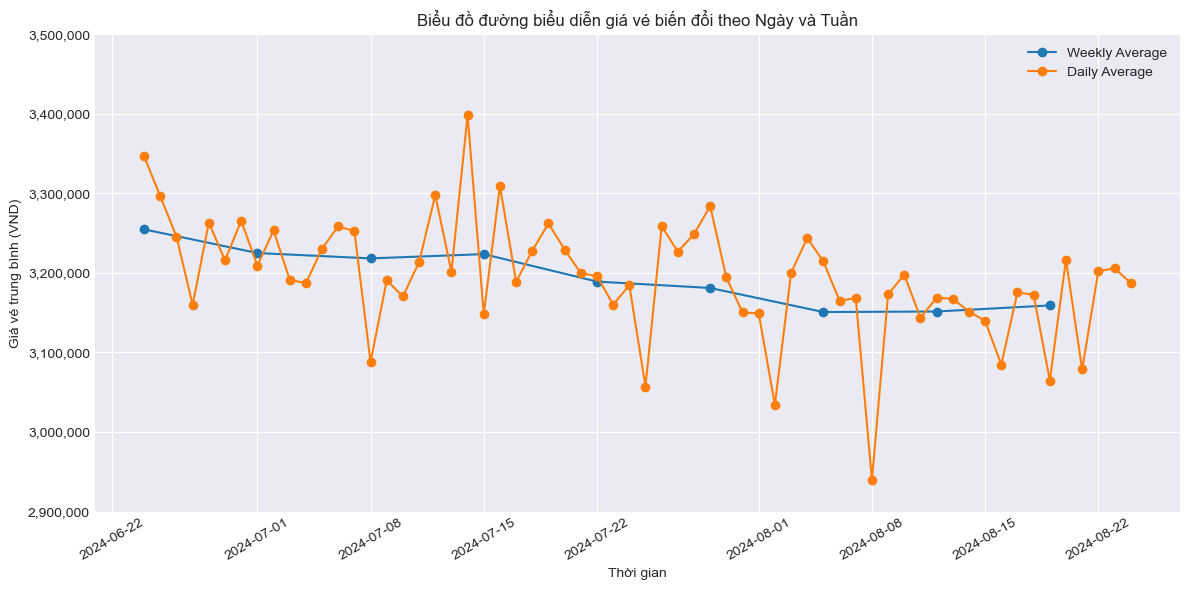

In [24]:
# Vẽ biểu đồ giá vé theo tuần
plt.figure(figsize=(12, 6))
plt.plot(weekly_avg.index.astype('datetime64[ns]'), weekly_avg.values, label='Weekly Average', marker='o')
plt.plot(daily_avg.index, daily_avg.values, label='Daily Average', marker='o')

plt.title('Biểu đồ đường biểu diễn giá vé biến đổi theo Ngày và Tuần')
plt.xlabel('Thời gian')
plt.ylabel('Giá vé trung bình (VND)')
plt.legend()

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{int(tick):,.0f}' for tick in yticks])
plt.xticks(rotation=30)

plt.tight_layout();

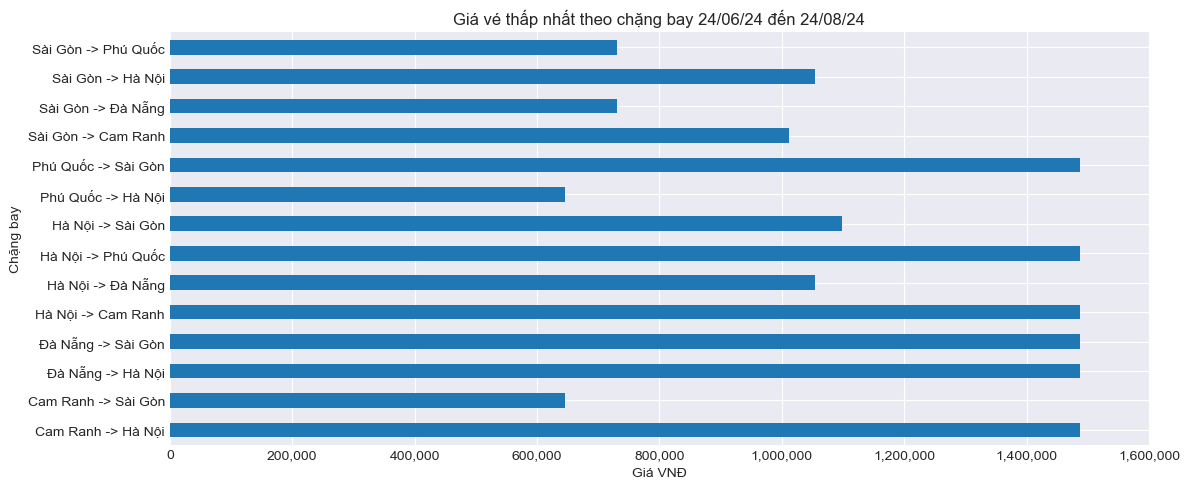

In [25]:
index_list = [
    'Cam Ranh -> Hà Nội',
    'Cam Ranh -> Sài Gòn',
    'Đà Nẵng -> Hà Nội',
    'Đà Nẵng -> Sài Gòn',
    'Hà Nội -> Cam Ranh',
    'Hà Nội -> Đà Nẵng',
    'Hà Nội -> Phú Quốc',
    'Hà Nội -> Sài Gòn',
    'Phú Quốc -> Hà Nội',
    'Phú Quốc -> Sài Gòn',
    'Sài Gòn -> Cam Ranh',
    'Sài Gòn -> Đà Nẵng',
    'Sài Gòn -> Hà Nội',
    'Sài Gòn -> Phú Quốc'
]

# Biểu đồ giá rẻ nhất theo chặng
plt.figure(figsize=(12, 5))
cheapest_per_route.plot(kind='barh', title='Giá vé thấp nhất theo chặng bay 24/06/24 đến 24/08/24', ylabel='Chặng bay', xlabel='Giá VNĐ')
xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{int(tick):,.0f}' for tick in xticks], rotation=0)
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=index_list)
plt.tight_layout();

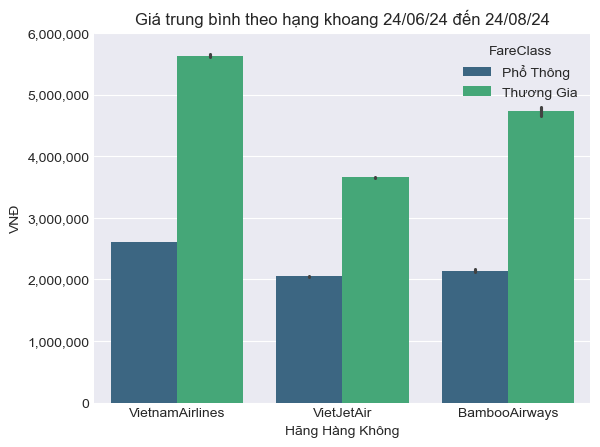

In [26]:
sns.barplot(data=df, y='Price', hue='FareClass', x='Airline', palette='viridis')
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{int(tick):,.0f}' for tick in yticks])
plt.title("Giá trung bình theo hạng khoang 24/06/24 đến 24/08/24")
plt.xlabel("Hãng Hàng Không")
plt.ylabel("VNĐ");

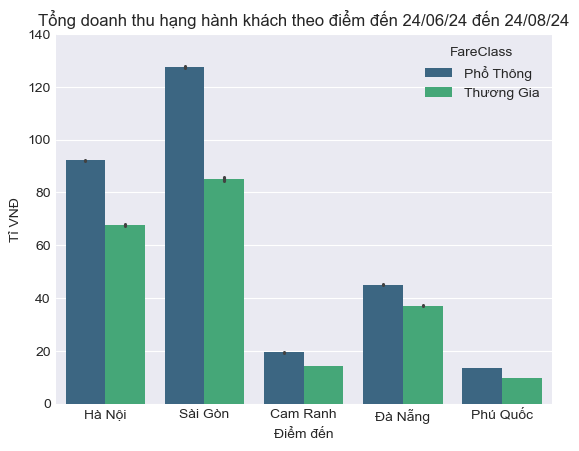

In [27]:
sns.barplot(data=df, y='Price', hue='FareClass', x='DestinationCity', estimator=sum, palette='viridis')
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{int(tick)/1000000000:,.0f}' for tick in yticks])
plt.title("Tổng doanh thu hạng hành khách theo điểm đến 24/06/24 đến 24/08/24")
plt.xlabel("Điểm đến")
plt.ylabel("Tỉ VNĐ");

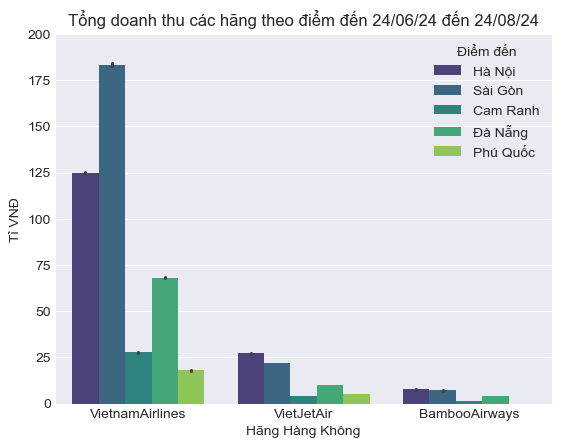

In [28]:
sns.barplot(data=df, y='Price', hue='DestinationCity', x='Airline', estimator=sum, palette='viridis')
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{int(tick/1000000000):,.0f}' for tick in yticks])
plt.title("Tổng doanh thu các hãng theo điểm đến 24/06/24 đến 24/08/24")
plt.xlabel("Hãng Hàng Không")
plt.ylabel("Tỉ VNĐ")
plt.legend(title='Điểm đến');

# Regression Analysis

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Future Day Pridiction

In [32]:
# Chuyển đổi Date thành số giây
df['Date_Numeric'] = df['Date'].astype('int64') // 10**9 

# Chọn biến cho mô hình hồi quy
X = df[['Date_Numeric']]
y = df['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

# Mô hình hồi quy
model = LinearRegression()
model.fit(X_train, y_train)

# Dự đoán giá vé trong tương lai
future_days = pd.DataFrame({'Date_Numeric': range(df['Date_Numeric'].max(), df['Date_Numeric'].max() + 24*60*60*10, 60*60*24)})
predictions = model.predict(future_days)
print(predictions)


[3148558.88285712 3146878.11912305 3145197.35538898 3143516.59165491
 3141835.82792084 3140155.06418677 3138474.30045269 3136793.53671862
 3135112.77298455 3133432.00925048]


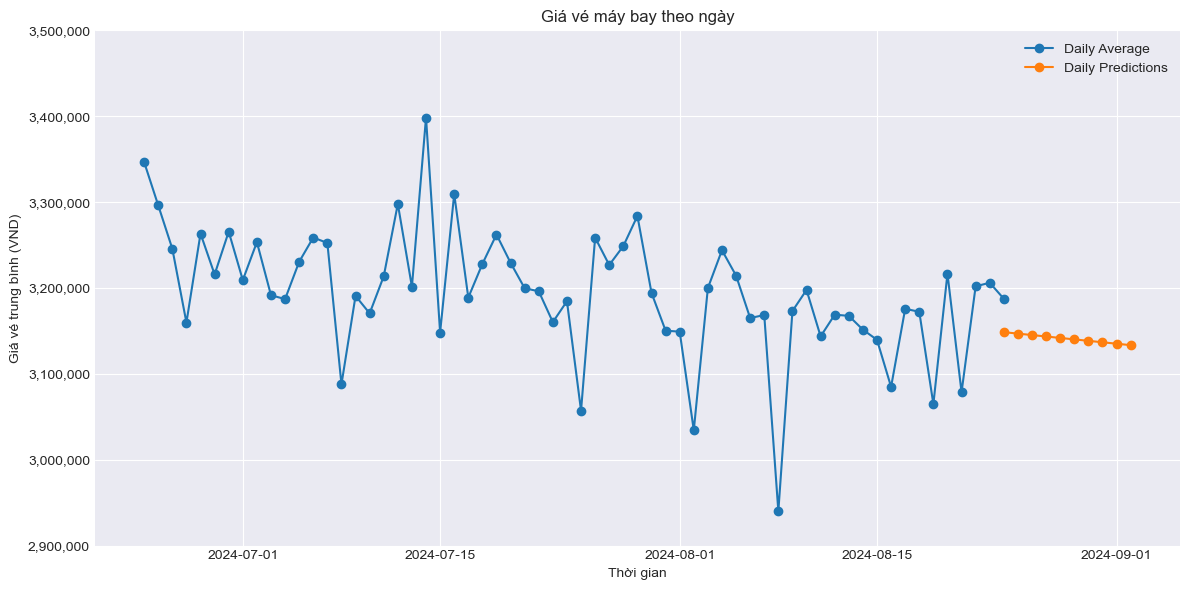

In [33]:
# Vẽ biểu đồ giá vé theo dự đoán giá tương lai theo ngày
plt.figure(figsize=(12, 6))
plt.plot(daily_avg.index, daily_avg.values, label='Daily Average', marker='o')
plt.plot(pd.to_datetime(future_days['Date_Numeric'], unit='s'), predictions, label='Daily Predictions', marker='o')

plt.title('Giá vé máy bay theo ngày')
plt.xlabel('Thời gian')
plt.ylabel('Giá vé trung bình (VND)')
plt.legend()

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{int(tick):,.0f}' for tick in yticks])

plt.tight_layout();

### Future Week Pridiction

In [35]:
# Chuyển đổi Date thành số tuần
df['Week_Numeric'] = df['Date'].dt.strftime('%Y%U').astype(int)

# Chọn biến cho mô hình hồi quy
X = df[['Week_Numeric']]
y = df['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mô hình hồi quy
model = LinearRegression()
model.fit(X_train, y_train)

# Dự đoán giá vé trong tương lai
future_weeks = pd.DataFrame({'Week_Numeric': range(df['Week_Numeric'].max(), df['Week_Numeric'].max() + 10)})
predictions = model.predict(future_weeks)
print(predictions)


[3150910.11535835 3139144.93623161 3127379.75710487 3115614.57797813
 3103849.39885139 3092084.21972513 3080319.04059839 3068553.86147165
 3056788.68234491 3045023.50321817]


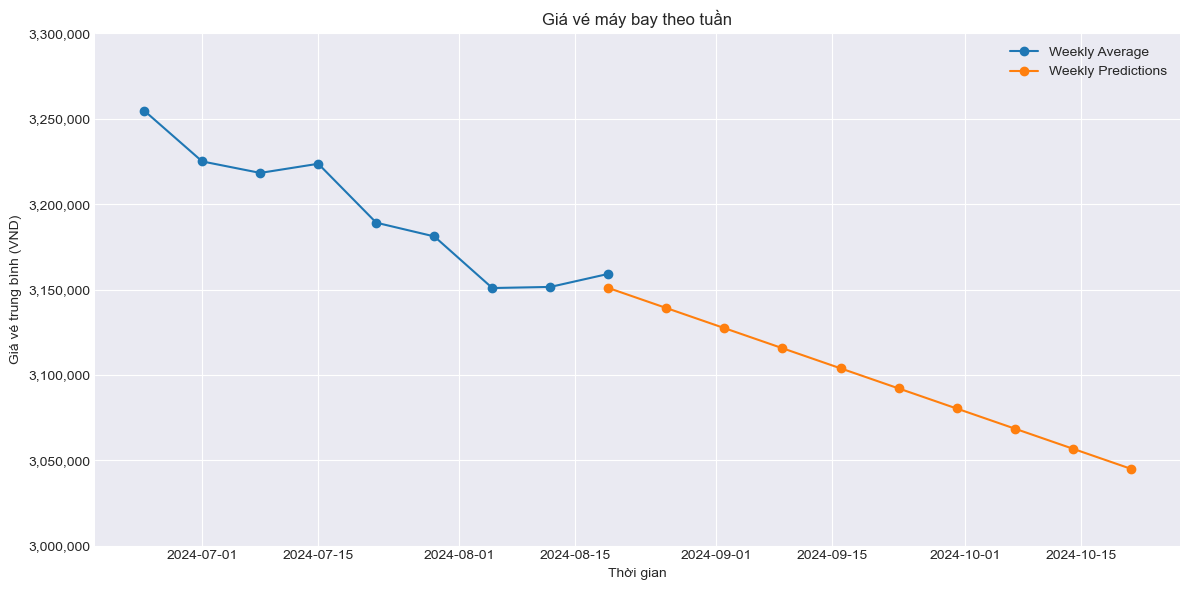

In [36]:
# Hàm chuyển week_numeric về datetime
def convert_to_date(week_numeric):
    year = week_numeric // 100  # Lấy phần năm
    week = week_numeric % 100    # Lấy phần tuần
    # Tạo ngày đầu tiên của tuần
    return pd.to_datetime(f'{year}-W{week}-1', format='%Y-W%U-%w')

# Vẽ biểu đồ giá vé theo dự đoán giá tương lai theo tuần
plt.figure(figsize=(12, 6))
plt.plot(weekly_avg.index.astype('datetime64[ns]'), weekly_avg.values, label='Weekly Average', marker='o')
plt.plot(future_weeks['Week_Numeric'].apply(convert_to_date), predictions, label='Weekly Predictions', marker='o')

plt.title('Giá vé máy bay theo tuần')
plt.xlabel('Thời gian')
plt.ylabel('Giá vé trung bình (VND)')
plt.legend()

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{int(tick):,.0f}' for tick in yticks])

plt.tight_layout();

In [37]:
#df.to_csv("flight_data_cleaned.csv", mode="w")